In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
data=pd.read_csv('2015-2016-building-energy-benchmarking.csv',index_col=0)
data.shape

(6700, 106)

In [19]:
data.loc[:, data.isnull().any()].isna().sum().sort_values(ascending=False)

ENERGYSTARScore               1610
log of TotalGHGEmissions        11
TotalGHGEmissions               11
log of SiteEnergyUse(kBtu)      10
SiteEnergyUse(kBtu)             10
dtype: int64

In [4]:
print(data.columns)

Index(['LargestPropertyUseTypeGFA', 'CouncilDistrictCode', 'YearBuilt',
       'NumberofFloors', 'DataYear', 'NumberofBuildings', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'PropertyGFATotal', 'TotalGHGEmissions',
       ...
       'Neighborhood_LAKE UNION', 'Neighborhood_MAGNOLIA / QUEEN ANNE',
       'Neighborhood_NORTH', 'Neighborhood_NORTHEAST',
       'Neighborhood_NORTHWEST', 'Neighborhood_SOUTHEAST',
       'Neighborhood_SOUTHWEST', 'ComplianceStatus_Compliant',
       'ComplianceStatus_Not Compliant', 'ComplianceStatus_Unknown'],
      dtype='object', length=106)


In [5]:
data.dtypes

LargestPropertyUseTypeGFA         float64
CouncilDistrictCode                 int64
YearBuilt                           int64
NumberofFloors                      int64
DataYear                            int64
                                   ...   
Neighborhood_SOUTHEAST              int64
Neighborhood_SOUTHWEST              int64
ComplianceStatus_Compliant          int64
ComplianceStatus_Not Compliant      int64
ComplianceStatus_Unknown            int64
Length: 106, dtype: object

In [21]:
#création des variables à expliquer
co2='TotalGHGEmissions'
energy='SiteEnergyUse(kBtu)'

cibles=[co2,energy]
log_cibles=['log of '+co2,'log of '+energy]

# Partie 1 : Evaluation sans ENERGYSTARScore

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import  mean_squared_error

import time
import datetime

In [74]:
data_without_ESS=data.drop(columns=['ENERGYSTARScore']+cibles)

data_without_ESS_nan_co2=data_ESS[data_ESS['log of TotalGHGEmissions'].isna()]
data_without_ESS_nan_energy=data_ESS[data_ESS['log of SiteEnergyUse(kBtu)'].isna()]

data_without_ESS_nan_co2.drop(columns=log_cibles,inplace=True)
data_without_ESS_nan_energy.drop(columns=log_cibles,inplace=True)

data_without_ESS.dropna(inplace=True)
data_without_ESS.shape

(6689, 103)

In [9]:
X=data_without_ESS.drop(columns=log_cibles)
Y=data_without_ESS[log_cibles]

X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=42)

In [10]:
from sklearn.dummy import DummyRegressor

dummy_scores=[]

for cible in log_cibles:
    dummy = DummyRegressor(strategy = 'mean').fit(X_train, Y_train[[cible]])
    dummy_scores.append(mean_squared_error(dummy.predict(X_test), Y_test[[cible]]))
    print(cible+' dummy mse: ',mean_squared_error(dummy.predict(X_test), Y_test[[cible]]))

log of TotalGHGEmissions dummy mse:  2.0054831309397483
log of SiteEnergyUse(kBtu) dummy mse:  1.8914459829309422


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

models=[
    LinearRegression(),
    RandomForestRegressor(),
    XGBRegressor(objective ='reg:squarederror')
]

model_names=[model.__class__.__name__ for model in models]

all_params=[
    {
        
    },
    {
             'n_estimators' : [10,20,50,100],
             'min_samples_leaf' : [5,10,20], 
             'max_features': ['auto','sqrt','log2']
    },
    {
             'n_estimators' : [100,200,500]
    }
]

i=0
fitted_models_and_mse=[]

times=[]
MSE=[]

for cible in log_cibles:
    print('variable:',cible,'\n')
    fitted_models_and_mse.append([])
    
    for model, params in zip(models, all_params):
        if (model.__class__.__name__=='LinearRegression'):
            model.fit(X_train,Y_train[[cible]])
            
            # temps d'inférence (prédiction)
            start_time = time.time()
            mse=mean_squared_error(model.predict(X_test),Y_test[[cible]])/dummy_scores[i]
            elapsed=time.time()-start_time
            elapsed/=len(Y_train[[cible]])
            
            MSE.append(mse)
            
            print(model.__class__.__name__+':')
            print('mse score:',mse)
            print('\n')
            
            times.append(elapsed)
            fitted_models_and_mse[i].append((model,mse))
        else:
            grid = GridSearchCV(model,
                                param_grid = params,
                                verbose=0,
                                cv=20)
            grid.fit(X_train, Y_train[[cible]].values.ravel())
            
            # temps d'inférence (prédiction)
            start_time = time.time()
            mse=mean_squared_error(grid.best_estimator_.predict(X_test),Y_test[[cible]])/dummy_scores[i]
            elapsed=time.time()-start_time
            elapsed/=len(Y_train[[cible]])
            
            MSE.append(mse)
                
            print(model.__class__.__name__+':')
            print('mse score:',mse)
            print('\n')
            
            times.append(elapsed)
            fitted_models_and_mse[i].append((grid.best_estimator_,mse))
    print('\n')
    i+=1
    
best_models=[]
for fitted in fitted_models_and_mse:
    best_models.append(min(fitted, key = lambda t: t[1])[0])
    
best_models

variable: log of TotalGHGEmissions 

LinearRegression:
mse score: 0.46203253393513133


RandomForestRegressor:
mse score: 0.2367179407675131


XGBRegressor:
mse score: 0.26519343934445233




variable: log of SiteEnergyUse(kBtu) 

LinearRegression:
mse score: 0.4998713216865392


RandomForestRegressor:
mse score: 0.38970848773878586


XGBRegressor:
mse score: 0.38337492668671036






[RandomForestRegressor(min_samples_leaf=5),
 XGBRegressor(n_estimators=200, objective='reg:squarederror')]

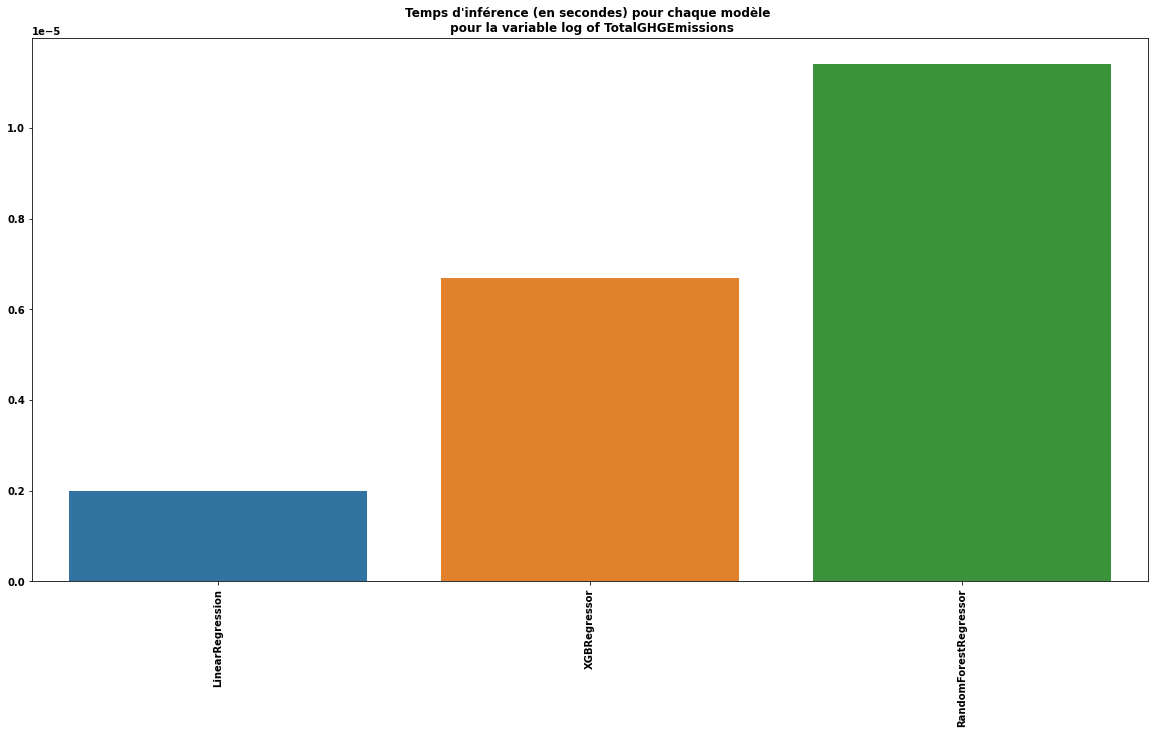

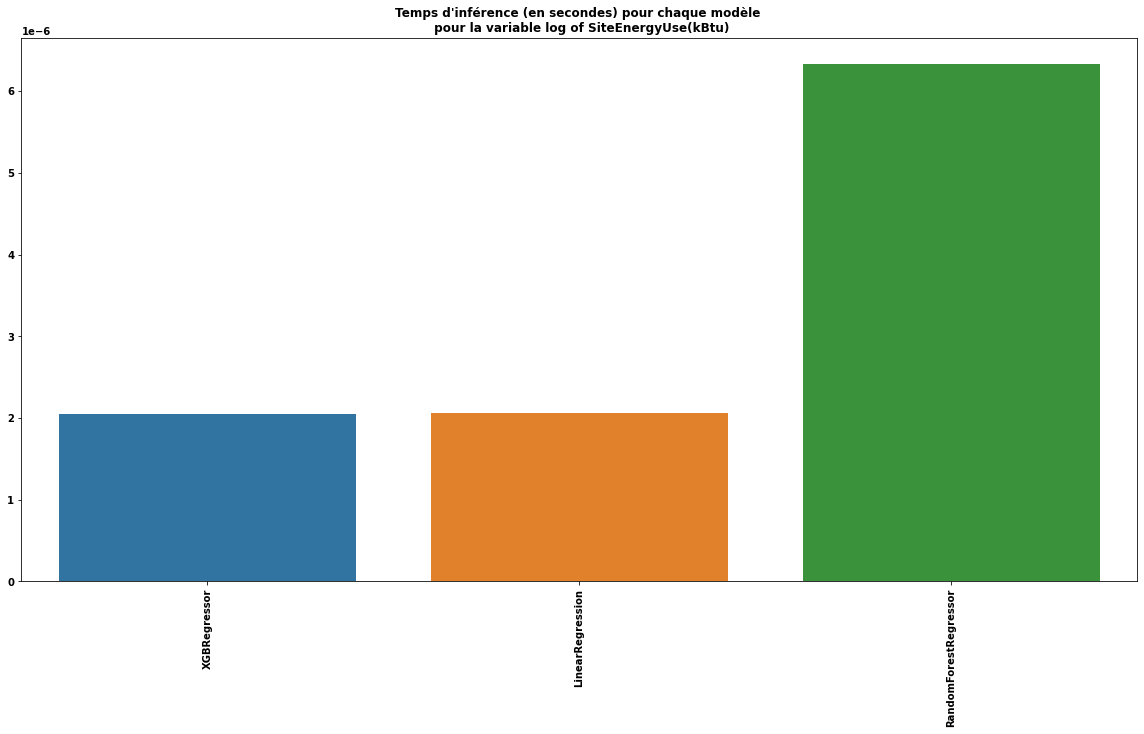

In [12]:
i=0
for cible in log_cibles:
    plt.figure(figsize=(20,10))
    plt.title('Temps d\'inférence (en secondes) pour chaque modèle \n pour la variable '+cible)
    plt.xticks(rotation=90)
    abscisse=[x for _, x in sorted(zip(times[i:i+len(models)], model_names))]
    ordonnee=sorted(times[i:i+len(models)])
    sns.barplot(x=abscisse, y=ordonnee)
    i+=len(models)

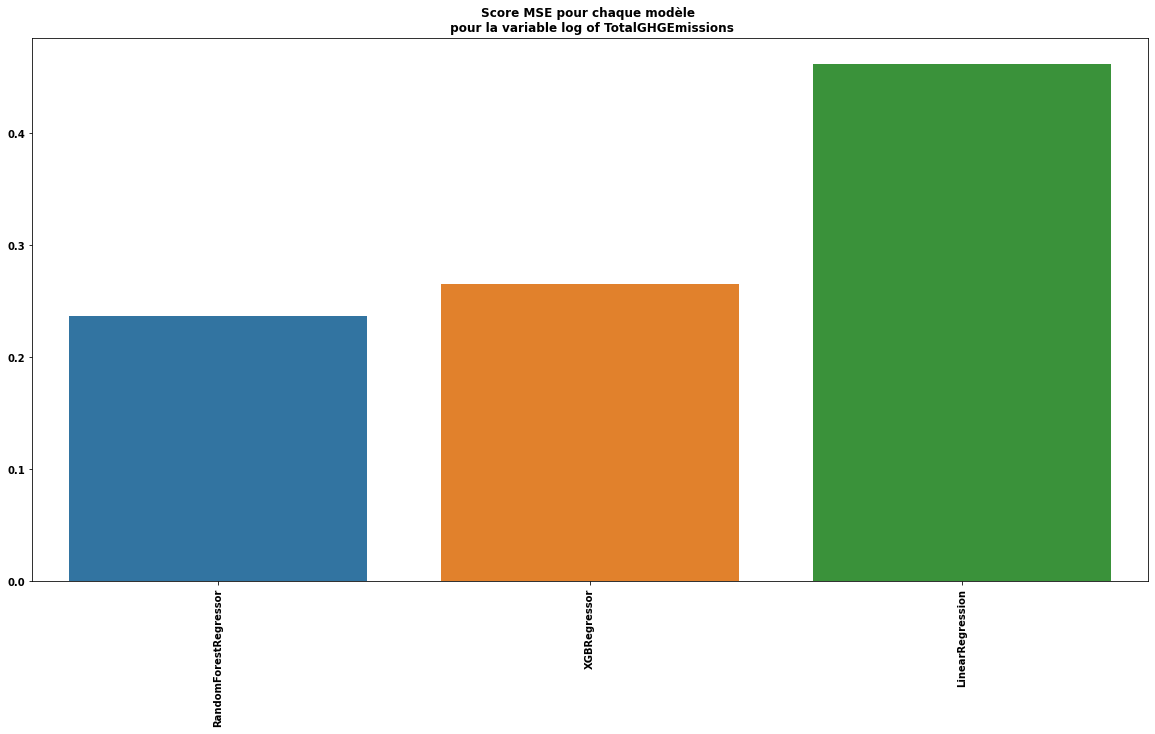

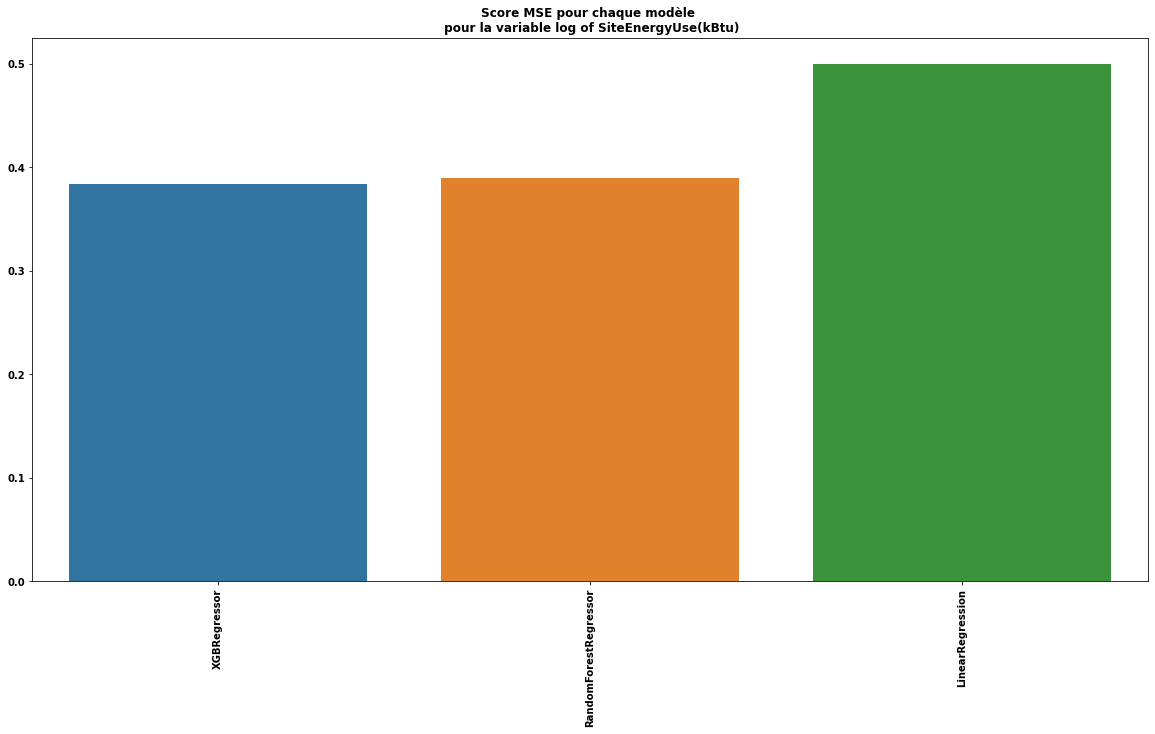

In [13]:
i=0
for cible in log_cibles:
    plt.figure(figsize=(20,10))
    plt.title('Score MSE pour chaque modèle \n pour la variable '+cible)
    plt.xticks(rotation=90)
    abscisse=[x for _, x in sorted(zip(MSE[i:i+len(models)], model_names))]
    ordonnee=sorted(MSE[i:i+len(models)])
    sns.barplot(x=abscisse, y=ordonnee)
    i+=len(models)

In [14]:
i=0
print('Test des modèles finaux:','\n')
for cible in log_cibles:
    print('variable: '+cible,'\n')
    mse=mean_squared_error(best_models[i].predict(X_test),Y_test[[cible]])/dummy_scores[i]
    print('modèle: '+best_models[i].__class__.__name__)
    print('mse:',mse,'\n')
    i+=1

Test des modèles finaux: 

variable: log of TotalGHGEmissions 

modèle: RandomForestRegressor
mse: 0.2367179407675131 

variable: log of SiteEnergyUse(kBtu) 

modèle: XGBRegressor
mse: 0.38337492668671036 



# Evaluation avec ENERGYSTARScore

In [25]:
data_ESS=data.drop(columns=[co2,energy])
data_ESS.shape

(6700, 104)

In [26]:
#one hot encoding ESS

data_OHE=pd.get_dummies(data_ESS[['ENERGYSTARScore']].astype(object),dummy_na=True)
data_ESS.drop(columns=['ENERGYSTARScore'],inplace=True)
data_ESS=pd.concat([data_ESS,data_OHE],axis=1)

data_ESS_nan_co2=data_ESS[data_ESS['log of TotalGHGEmissions'].isna()]
data_ESS_nan_energy=data_ESS[data_ESS['log of SiteEnergyUse(kBtu)'].isna()]

data_ESS_nan_co2.drop(columns=log_cibles,inplace=True)
data_ESS_nan_energy.drop(columns=log_cibles,inplace=True)

data_ESS.dropna(inplace=True)
data_ESS.shape

(6689, 204)

In [29]:
X_ESS=data_ESS.drop(columns=log_cibles)
Y_ESS=data_ESS[log_cibles]

X_train_ESS, X_test_ESS, Y_train_ESS, Y_test_ESS = train_test_split(X_ESS,
                                                                    Y_ESS,
                                                                    test_size=0.2,
                                                                    random_state=42)

In [30]:
from sklearn.dummy import DummyRegressor

dummy_scores_ESS=[]

for cible in log_cibles:
    dummy = DummyRegressor(strategy = 'mean').fit(X_train_ESS, Y_train_ESS[[cible]])
    dummy_scores_ESS.append(mean_squared_error(dummy.predict(X_test_ESS), Y_test_ESS[[cible]]))
    print(cible+' dummy score: ',mean_squared_error(dummy.predict(X_test_ESS), Y_test_ESS[[cible]]))

log of TotalGHGEmissions dummy score:  2.0054831309397483
log of SiteEnergyUse(kBtu) dummy score:  1.8914459829309422


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

i=0
fitted_models_and_mse_ESS=[]
times=[]
MSE=[]

for cible in log_cibles:
    print('variable:',cible,'\n')
    fitted_models_and_mse_ESS.append([])
    
    for model, params in zip(models, all_params):
        start_time=time.time()
        if (model.__class__.__name__=='LinearRegression'):
            model.fit(X_train_ESS,Y_train_ESS[[cible]])
            
            # temps d'inférence (prédiction)
            start_time = time.time()
            mse=mean_squared_error(model.predict(X_test_ESS),Y_test_ESS[[cible]])/dummy_scores_ESS[i]
            elapsed=time.time()-start_time
            elapsed/=len(Y_train[[cible]])
            
            MSE.append(mse)
            
            print(model.__class__.__name__+':')
            print('mse score:',mse)
            print('\n')
            
            times.append(elapsed)
            fitted_models_and_mse_ESS[i].append((model,mse))
        else:
            grid = GridSearchCV(model,
                                param_grid = params,
                                verbose=0,
                                cv=20)
            grid.fit(X_train_ESS, Y_train_ESS[[cible]].values.ravel())
            
            # temps d'inférence (prédiction)
            start_time = time.time()
            mse=mean_squared_error(grid.best_estimator_.predict(X_test_ESS),Y_test_ESS[[cible]])/dummy_scores_ESS[i]
            elapsed=time.time()-start_time
            elapsed/=len(Y_train[[cible]])
            
            MSE.append(mse)
                
            print(model.__class__.__name__+':')
            print('mse score:',mse)
            print('\n')
            
            times.append(elapsed)
            fitted_models_and_mse_ESS[i].append((grid.best_estimator_,mse))
    print('\n')
    i+=1
    
best_models_ESS=[]
for fitted in fitted_models_and_mse_ESS:
    best_models_ESS.append(min(fitted, key = lambda t: t[1])[0])
    
best_models_ESS

variable: log of TotalGHGEmissions 

LinearRegression:
mse score: 0.45683196581936647


RandomForestRegressor:
mse score: 0.23234762381738797


XGBRegressor:
mse score: 0.2772922298858922




variable: log of SiteEnergyUse(kBtu) 

LinearRegression:
mse score: 0.482641557579804


RandomForestRegressor:
mse score: 0.2170192649027919


XGBRegressor:
mse score: 0.1851622007000969






[RandomForestRegressor(min_samples_leaf=5),
 XGBRegressor(n_estimators=500, objective='reg:squarederror')]

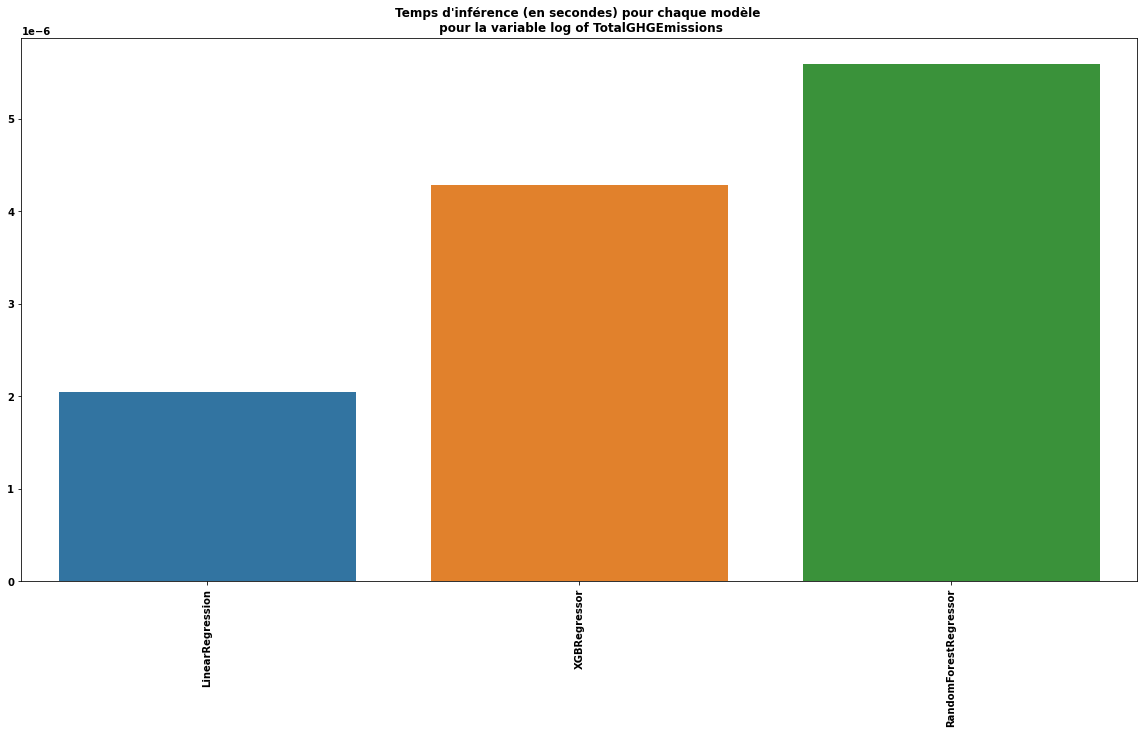

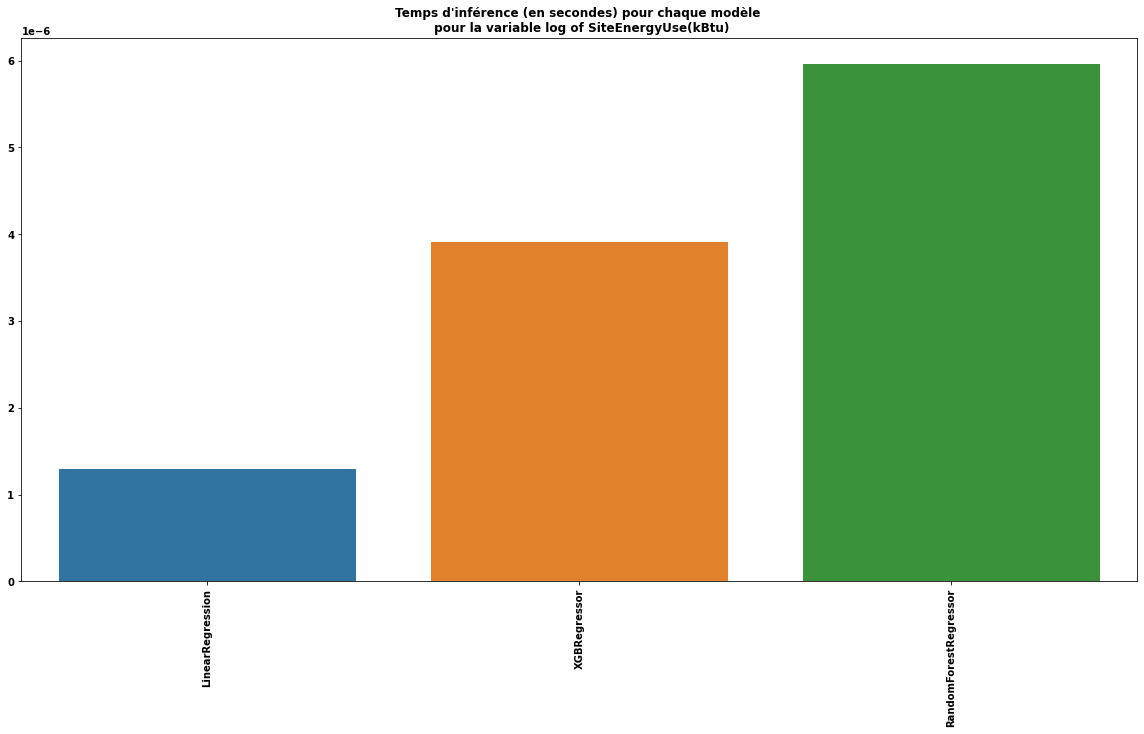

In [20]:
i=0
for cible in log_cibles:
    plt.figure(figsize=(20,10))
    plt.title('Temps d\'inférence (en secondes) pour chaque modèle \n pour la variable '+cible)
    plt.xticks(rotation=90)
    abscisse=[x for _, x in sorted(zip(times[i:i+len(models)], model_names))]
    ordonnee=sorted(times[i:i+len(models)])
    sns.barplot(x=abscisse, y=ordonnee)
    i+=len(models)

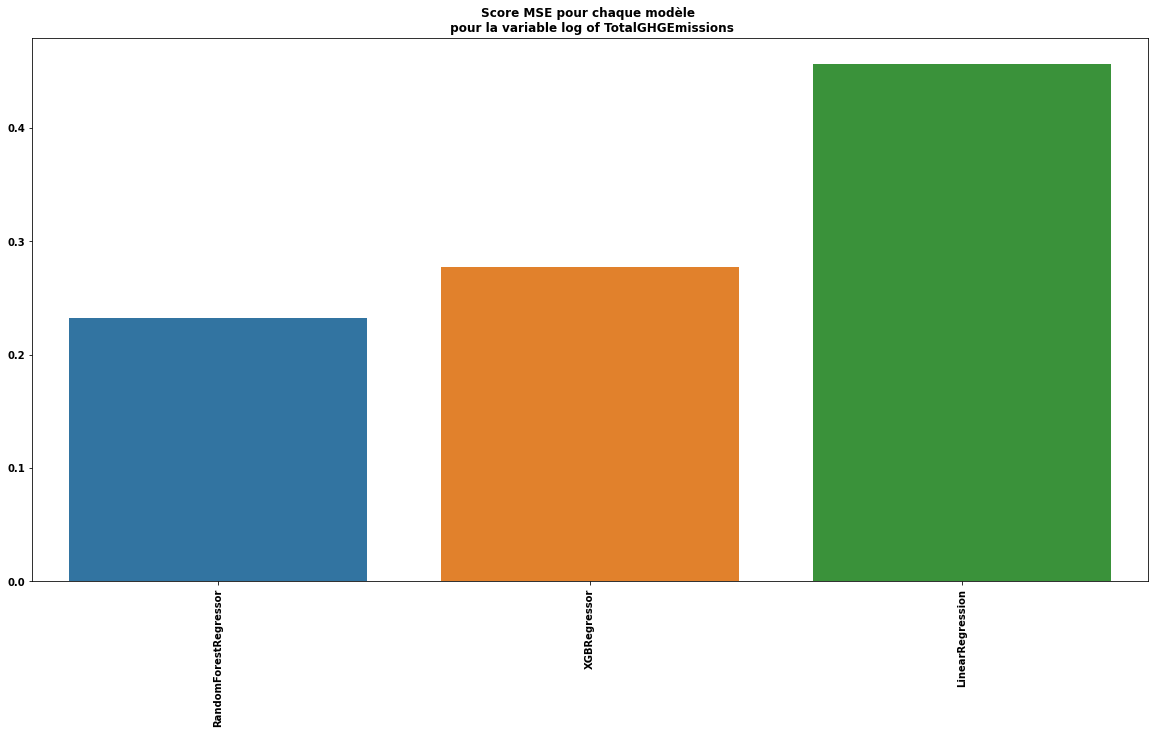

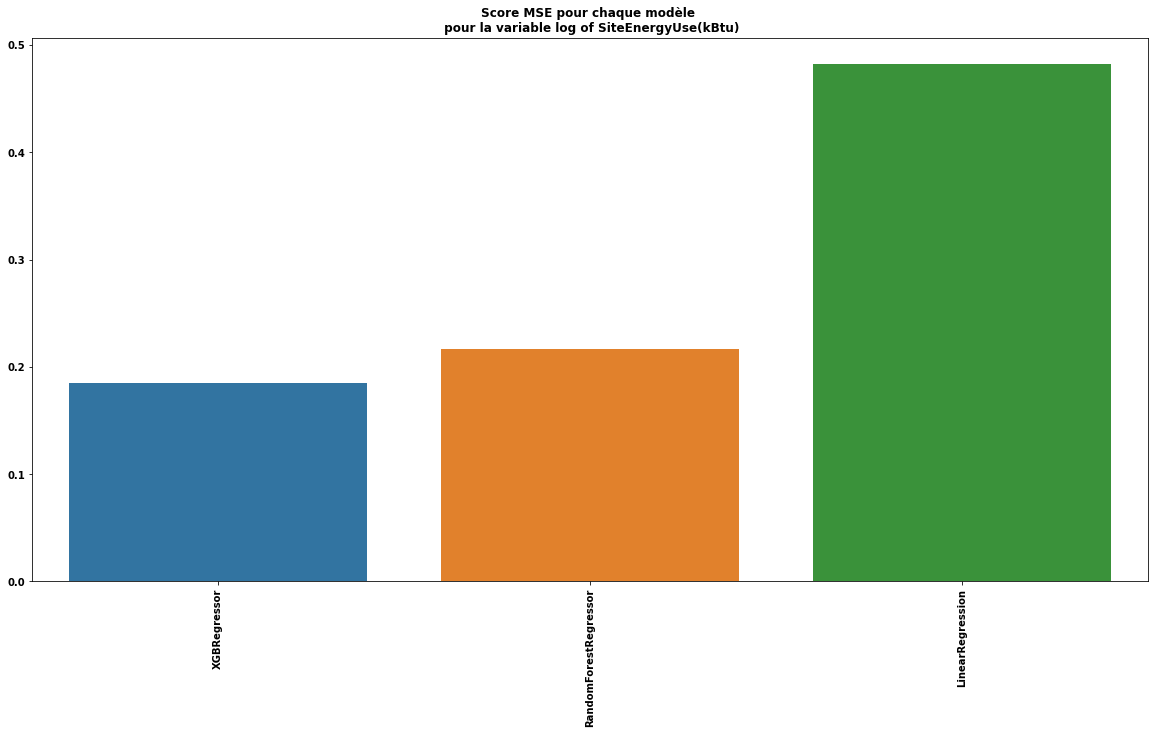

In [21]:
i=0
for cible in log_cibles:
    plt.figure(figsize=(20,10))
    plt.title('Score MSE pour chaque modèle \n pour la variable '+cible)
    plt.xticks(rotation=90)
    abscisse=[x for _, x in sorted(zip(MSE[i:i+len(models)], model_names))]
    ordonnee=sorted(MSE[i:i+len(models)])
    sns.barplot(x=abscisse, y=ordonnee)
    i+=len(models)

In [22]:
i=0
print('Test des modèles finaux:','\n')
for cible in log_cibles:
    print('variable: '+cible,'\n')
    mse=mean_squared_error(best_models_ESS[i].predict(X_test_ESS),Y_test_ESS[[cible]])/dummy_scores_ESS[i]
    print('modèle: '+best_models_ESS[i].__class__.__name__)
    print('mse:',mse,'\n')
    i+=1

Test des modèles finaux: 

variable: log of TotalGHGEmissions 

modèle: RandomForestRegressor
mse: 0.23234762381738797 

variable: log of SiteEnergyUse(kBtu) 

modèle: XGBRegressor
mse: 0.1851622007000969 



# Prédiction des données manquantes à l'aide des meilleurs modèles

In [75]:
model_final_co2=best_models_ESS[0]
co2_pred=pd.DataFrame(data=model_final_co2.predict(data_ESS_nan_co2),
                      index=data_ESS_nan_co2.index,columns=['prediction of '+co2])
co2_pred['prediction of '+co2]=np.exp(co2_pred['prediction of '+co2])-1+min(data[co2].values)

In [76]:
co2_pred

,prediction of TotalGHGEmissions
OSEBuildingID,
24408,197.924
25451,34.767
25361,52.471
23508,66.659
19798,8.345
19694,62.761
87,39.412
21578,33.725
21570,43.475


In [77]:
model_final_energy=best_models_ESS[1]
energy_pred=pd.DataFrame(data=model_final_energy.predict(data_ESS_nan_energy),
                         index=data_ESS_nan_energy.index,columns=['prediction of '+energy])
energy_pred['prediction of '+energy]=np.exp(energy_pred['prediction of '+energy])-1+min(data[energy].values)

In [78]:
energy_pred

,prediction of SiteEnergyUse(kBtu)
OSEBuildingID,
24408,4333904.000
25451,6512019.500
25361,2109633.000
23508,546.429
19798,1752.756
19694,1796634.500
87,94808.984
21578,1007898.062
21570,1421986.750
